### Out-of-Bag

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждог объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

In [1490]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [1491]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

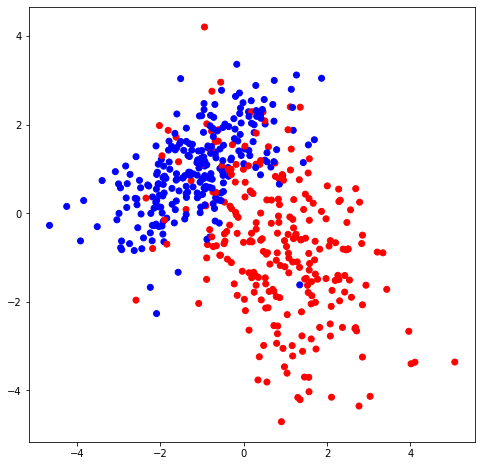

In [1492]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [1493]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_idx[j] = sample_index
        bootstrap.append((b_data, b_labels, b_idx))

    return bootstrap

In [1494]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [1495]:
def outofbag(bootst):
    bag_ind = []
    bag_ind = list(set(range(len(bootst))) - set(bootst))
    return np.array(bag_ind)

In [1496]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [1497]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [1498]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [1499]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [1500]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [1501]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1502]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [1503]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    boot_ind = bootstrap[0][2]
   
    oof = outofbag(bootstrap[0][2])

    for b_data, b_labels, b_idx in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        

    oof_data=[]
    oof_labels=[]
    for i in oof:
        oof_data.append(data[i])
        oof_labels.append(labels[i])
        
    for tree in forest:
        y_pred = predict(oof_data, tree)
        score = accuracy_metric(oof_labels, y_pred)
        print(f"N of Trees = {n_trees}, OutOfObag Score = {score}")
    return forest

In [1504]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [1505]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [1506]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [1507]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [1508]:
  # Введем функцию подсчета точности как доли правильных ответов

  def accuracy_metric(actual, predicted):
      correct = 0
      for i in range(len(actual)):
          if actual[i] == predicted[i]:
              correct += 1
      return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [1509]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)


N of Trees = 1, OutOfObag Score = 81.95488721804512


In [1510]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [1511]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [1512]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 93.143


In [1513]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 93.333


Построим лес из трех деревьев

In [1514]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

N of Trees = 3, OutOfObag Score = 88.0
N of Trees = 3, OutOfObag Score = 93.60000000000001
N of Trees = 3, OutOfObag Score = 95.19999999999999


In [1515]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [1516]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [1517]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.429


In [1518]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 96.000


Построим лес из десяти деревьев

In [1519]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

N of Trees = 10, OutOfObag Score = 85.12396694214877
N of Trees = 10, OutOfObag Score = 90.08264462809917
N of Trees = 10, OutOfObag Score = 92.56198347107438
N of Trees = 10, OutOfObag Score = 95.86776859504133
N of Trees = 10, OutOfObag Score = 94.21487603305785
N of Trees = 10, OutOfObag Score = 88.42975206611571
N of Trees = 10, OutOfObag Score = 96.69421487603306
N of Trees = 10, OutOfObag Score = 95.0413223140496
N of Trees = 10, OutOfObag Score = 95.0413223140496
N of Trees = 10, OutOfObag Score = 93.38842975206612


In [1520]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [1521]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [1522]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.143


In [1523]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 96.667


Построим лес из пятидесяти деревьев

In [1524]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

N of Trees = 50, OutOfObag Score = 90.0
N of Trees = 50, OutOfObag Score = 93.07692307692308
N of Trees = 50, OutOfObag Score = 93.07692307692308
N of Trees = 50, OutOfObag Score = 95.38461538461539
N of Trees = 50, OutOfObag Score = 94.61538461538461
N of Trees = 50, OutOfObag Score = 93.07692307692308
N of Trees = 50, OutOfObag Score = 94.61538461538461
N of Trees = 50, OutOfObag Score = 92.3076923076923
N of Trees = 50, OutOfObag Score = 93.07692307692308
N of Trees = 50, OutOfObag Score = 96.15384615384616
N of Trees = 50, OutOfObag Score = 96.15384615384616
N of Trees = 50, OutOfObag Score = 95.38461538461539
N of Trees = 50, OutOfObag Score = 94.61538461538461
N of Trees = 50, OutOfObag Score = 92.3076923076923
N of Trees = 50, OutOfObag Score = 94.61538461538461
N of Trees = 50, OutOfObag Score = 94.61538461538461
N of Trees = 50, OutOfObag Score = 92.3076923076923
N of Trees = 50, OutOfObag Score = 96.92307692307692
N of Trees = 50, OutOfObag Score = 93.07692307692308
N of Tree

In [1525]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [1526]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [1527]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [1528]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 97.333
